In [11]:
import os
import sys

import numpy as np
import math
import healpy as hp

# Plotting
import cmocean
import cmocean.cm as cmo
import cmasher as cmr
import seaborn as sns
import pylab as plt
import matplotlib as mpl
import matplotlib.pyplot as pyplot
from matplotlib.ticker import MultipleLocator

import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
import colorsys
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker

# Cosmoglobe 
import cosmoglobe as cg

import astropy.units as u
import astropy.constants as c
#from astropy import visualization
#visualization.quantity_support()
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d

import matplotlib.transforms as transforms

In [28]:
plt.rcParams['font.size'] = '16'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['axes.titlepad'] = 18
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif"
})
plt.rcParams["errorbar.capsize"] = 5

In [13]:
def dBdT(nu, T):
    x = c.h*nu/(c.k_B*T)
    A = 2*c.k_B*nu**2/c.c**2
    return (x.si**2*np.exp(x.si)/np.expm1(x.si)**2).to('')

In [14]:
# def build_combined_sed_with_precomputed_mbb(
#     nu,                # 1D array of frequencies corresponding to the precomputed MBB
#     sed_mbb,           # 1D array, precomputed MBB SED (Quantity)
#     data,              # tabulated SED data: columns [nu_min, nu_max, amplitude]
#     nu_transition=1e3, # GHz, transition frequency
#     transition_width=0.2
# ):
#     """
#     Smoothly join a precomputed low-frequency MBB SED to a high-frequency tabulated SED.
#     Units are hardcoded: tabulated amplitudes are assumed to be MJy/sr.

#     Parameters
#     ----------
#     nu : array-like or Quantity
#         Frequencies corresponding to the precomputed MBB
#     sed_mbb : Quantity
#         Precomputed MBB SED (must have units)
#     data : array, shape (N,3)
#         Columns: [nu_min, nu_max, amplitude]
#     nu_transition : float
#         Frequency (GHz) at which to join the MBB to the spline
#     transition_width : float
#         Fractional log-width of transition region

#     Returns
#     -------
#     sed_total : callable
#         Function sed_total(nu) returning combined SED (Quantity)
#     sed_spline : callable
#         High-frequency spline (Quantity)
#     nu_eff : Quantity
#         Effective bin centres
#     amp : Quantity
#         Tabulated amplitudes (with units)
#     mbb_norm : Quantity
#         Normalisation factor applied to MBB to match spline at transition
#     """

#     # --- tabulated SED ---
#     amp_unit = u.MJy / u.sr
#     nu_min = data[:, 0] * u.GHz
#     nu_max = data[:, 1] * u.GHz
#     amp    = data[:, 2] * amp_unit

#     nu_eff = np.sqrt(nu_min * nu_max) # central frequency per bin
#     mask = amp.value > 0
#     nu_eff = nu_eff[mask]
#     amp    = amp[mask]

#     # build spline in log-log space
#     spline = CubicSpline(np.log(nu_eff.to_value(u.GHz)),
#                          np.log(amp.to_value(amp.unit)),
#                          bc_type="natural")

#     def sed_spline(nu):
#         nu = u.Quantity(nu, u.GHz, copy=False)
#         val = np.exp(spline(np.log(nu.to_value(u.GHz))))
#         return val * amp.unit

#     # --- normalise MBB at transition ---
#     sed_spl_0 = sed_spline(nu_transition * u.GHz)
#     sed_mbb_0 = np.interp(np.log(nu_transition),
#                            np.log(nu.to_value(u.GHz)),
#                            sed_mbb.value) * sed_mbb.unit
#     mbb_norm = (sed_spl_0 / sed_mbb_0).decompose()

#     # --- smooth transition ---
#     def transition_weight(nu):
#         nu = u.Quantity(nu, u.GHz, copy=False)
#         x = (np.log(nu.to_value(u.GHz)) - np.log(nu_transition)) / transition_width
#         return 0.5 * (1 + np.tanh(x))

#     # --- combined SED ---
#     def sed_total(nu):
#         nu = u.Quantity(nu, u.GHz, copy=False)
#         w = transition_weight(nu)
#         sed_low  = mbb_norm * np.interp(np.log(nu.to_value(u.GHz)),
#                                        np.log(nu.to_value(u.GHz)), sed_mbb.value) * sed_mbb.unit
#         sed_high = sed_spline(nu)
#         return (1 - w) * sed_low + w * sed_high

#     return sed_total, sed_spline, nu_eff, amp, mbb_norm

In [15]:
def build_combined_sed_scale_tabulated(
    nu,
    sed_mbb,
    data,
    nu_transition=1.1e3,  # GHz
    transition_width=0.2
):
    """
    Smoothly join a fixed MBB to a tabulated SED by scaling the tabulated SED
    so it matches the MBB at nu_transition.
    Ensures the spline does not influence frequencies below its first tabulated bin.
    """

    amp_unit = u.MJy / u.sr
    nu_min = data[:, 0] * u.GHz
    nu_max = data[:, 1] * u.GHz
    amp = data[:, 2] * amp_unit

    nu_eff = np.sqrt(nu_min * nu_max)
    mask = amp.value > 0
    nu_eff = nu_eff[mask]
    amp = amp[mask]

    # --- build spline from tabulated amplitudes ---
    spline = CubicSpline(np.log(nu_eff.to_value(u.GHz)),
                         np.log(amp.to_value(amp.unit)),
                         bc_type="natural",
                         extrapolate=True  # allow extrapolation temporarily
                         )

    def sed_spline_raw(nu):
        nu = u.Quantity(nu, u.GHz)
        val = np.exp(spline(np.log(nu.to_value(u.GHz)))) * amp.unit
        return val

    # --- compute scale factor at transition ---
    sed_spline_at_trans = sed_spline_raw(nu_transition * u.GHz)
    sed_mbb_at_trans = np.interp(
        np.log(nu_transition),
        np.log(nu.to_value(u.GHz)),
        sed_mbb.value
    ) * sed_mbb.unit
    scale_factor = (sed_mbb_at_trans / sed_spline_at_trans).decompose()

    # --- scale amplitudes ---
    amp_scaled = amp * scale_factor

    # --- rebuild spline from scaled tabulated amplitudes ---
    # spline_scaled = CubicSpline(np.log(nu_eff.to_value(u.GHz)),
    #                             np.log(amp_scaled.to_value(amp_scaled.unit)),
    #                             bc_type="natural",
    #                             extrapolate=True)

    dlogamp_dlognu = np.gradient(np.log(amp_scaled.to_value(amp_scaled.unit)),
                                 np.log(nu_eff.to_value(u.GHz)))
    spline_scaled = CubicSpline(np.log(nu_eff.to_value(u.GHz)),
                                np.log(amp_scaled.to_value(amp_scaled.unit)),
                                bc_type=((1, dlogamp_dlognu[0]), (1, 0)),
                                # extrapolate=False)
                                extrapolate=True)

    def sed_spline(nu):
        nu = u.Quantity(nu, u.GHz)
        val = np.exp(spline_scaled(np.log(nu.to_value(u.GHz)))) * amp_scaled.unit
        return val

    # --- smooth transition ---
    def transition_weight(nu):
        nu = u.Quantity(nu, u.GHz)
        x = (np.log(nu.to_value(u.GHz)) - np.log(nu_transition)) / transition_width
        return 0.5 * (1 + np.tanh(x))

    # --- combined SED ---
    def sed_total(nu):
        nu = u.Quantity(nu, u.GHz)
        w = transition_weight(nu)

        # interpolate MBB to requested nu
        sed_low = np.interp(np.log(nu.to_value(u.GHz)),
                            np.log(nu.to_value(u.GHz)),
                            sed_mbb.value) * sed_mbb.unit

        sed_high = sed_spline(nu)

        # below first tabulated frequency, use MBB entirely
        sed_comb = (1 - w) * sed_low + w * sed_high
        sed_comb[nu < nu_eff.min()] = sed_low[nu < nu_eff.min()]

        return sed_comb

    return sed_total, sed_spline, nu_eff, amp_scaled, scale_factor

In [16]:
model = cg.sky_model(nside=1)

Initializing model from cached chainfile


synch: 100%|█████████████████████████████████| 6/6 [00:01<00:00,  4.46it/s]


In [29]:
def plot_comp(real_units=True,
              plot_ff=True,
              plot_sd=True,
              plot_synch=True,
              plot_cold_dust=True,
              plot_hot_dust=True,
              plot_Halpha=True,
              plot_nearby_dust=True,
              plot_bestfit_dust=True,
              plot_zodi=True,
              plot_stars=True,
              plot_cib_bethermin=False,
              plot_cib_finke=True,
              plot_cmb=True,
              plot_bands=True,
              background=False):


    fontsize = 13
    alpha = 0.82
    lw = 15
    
    nu = np.geomspace(0.4, 4e05, 1000) * u.GHz

    # Component spectra from cosmoglobe.model
    ff = model.components["ff"].get_freq_scaling(nu, T_e=8000 * u.K) * u.uK
    synch = model.components["synch"].get_freq_scaling(nu, -3.1) * u.uK
    sd = model.components["ame"].get_freq_scaling(nu, 20 * u.GHz) * u.uK

    cold_dust = model.components["dust"].get_freq_scaling(nu, 1.85, 11 * u.K) * u.uK
    hot_dust = model.components["dust"].get_freq_scaling(nu, 1.75, 30 * u.K) * u.uK
    Halpha = model.components["dust"].get_freq_scaling(nu, 2.62, 17.8 * u.K) * u.uK
    nearby_dust = model.components["dust"].get_freq_scaling(nu, 1.7, 18 * u.K) * u.uK

    zodi = model.components["dust"].get_freq_scaling(nu, 0, 200 * u.K) * u.uK
    cmb = model.components["dust"].get_freq_scaling(nu, 0, 2.7 * u.K) * u.uK
    cold_stars = model.components["dust"].get_freq_scaling(nu, 0, 2000 * u.K) * u.uK

    def uK_to_MJy(freq):
        return (2 * c.k_B * freq**2 / c.c**2).to("MJy/uK")

    def MJy_to_uK(freq):
        return (c.c**2 / (2 * c.k_B * freq**2)).to("uK/MJy")

    C = uK_to_MJy(nu) if real_units else 1


    # Components
    if plot_ff:
        ff_supp = np.exp(-((c.h * nu) / (c.k_B * 1e4 * u.K)).to("").value)
        plt.loglog(nu, C * ff[0] * 25 * ff_supp, #label="Free-free", 
                   color='lightsteelblue', lw=lw, alpha=alpha)
        plt.annotate(
            "Free-free",
            xy=(0.5, 1.25e-03),
            xytext=(0.5, 1.25e-03),
            color="black",
            fontweight="bold",
            fontsize=fontsize, rotation=-0.7
        )

    if plot_synch:
        plt.loglog(nu,  C * synch[0] * 5e6, #label="Synchrotron", 
                   color='xkcd:faded green', lw=lw, alpha=alpha)
        plt.annotate(
            "Synchrotron",
            xy=(0.9, 0.17e-02),
            xytext=(0.9, 0.17e-02),
            color="black",
            fontweight="bold",
            fontsize=fontsize, rotation=-15
        )

    
    if plot_cmb:
        plt.plot(nu,C * dBdT(nu, 2.7275 * u.K) * 75 * u.uK, #label="CMB fluctuations",
                 color='xkcd:faded purple', lw=lw, alpha=alpha)
        plt.annotate(
            "CMB",
            xy=(3.4e01, 0.2e-02),
            xytext=(3.4e01, 0.2e-02),
            color="white",
            fontweight="bold",
            fontsize=fontsize,
            rotation=25
        )

    if plot_stars:
        plot_stars = C * cold_stars[0] * 2e-2
        plt.plot(nu, plot_stars, # label="Cold stars", 
                 lw=lw, alpha=alpha, color='plum')
        plt.annotate(
            "Stars",
            # xy=(0.32*1e06, 1e-03),
            # xytext=(0.32*1e06, 1e-03),
            xy=(1.4e03, 1e-03),
            xytext=(1.4e03, 1e-03),
            color="black",
            fontweight="bold",
            fontsize=fontsize, #rotation=-68
            rotation=30
        )

    # Zodiacal light (DIRBE + Planck)
    if plot_zodi:
        sed_dirbe = np.load("sed_dirbe_zodi.npy")
        wav_dirbe = np.load("nu_dirbe_zodi.npy") * u.micron
        nu_dirbe = (c.c / wav_dirbe).to("GHz")

        sed_planck = np.load("sed_planck_zodi.npy")
        wav_planck = np.load("nu_planck_zodi.npy") * u.micron
        nu_planck = (c.c / wav_planck).to("GHz")

        nu_zodi = np.concatenate([nu_dirbe, nu_planck])
        sed_zodi = np.concatenate([sed_dirbe, sed_planck])

        C_zodi = uK_to_MJy(nu_zodi) if real_units else 1
        plot_zodi = C_zodi * MJy_to_uK(nu_zodi) * sed_zodi
        plt.plot(nu_zodi, plot_zodi, #label="Zodi", 
                 color='xkcd:sandy', lw=lw, alpha=alpha)
        
        # plt.annotate(
        #     "Zodiacal light",
        #     xy=(0.18e04, 1),
        #     xytext=(0.18e04, 1),
        #     color="black",
        #     fontweight="bold",
        #     fontsize=fontsize, rotation=24
        # )

        plt.annotate(
            "Zodia",
            xy=(7e03, 1.1e01),
            xytext=(7e03, 1.1e01),
            color="black",
            fontweight="bold",
            fontsize=fontsize, rotation=12
        )

        plt.annotate(
            "cal",
            xy=(1.35e04, 1.8e01),
            xytext=(1.35e04, 1.8e01),
            color="black",
            fontweight="bold",
            fontsize=fontsize, rotation=-2
        )

        plt.annotate(
            "light",
            xy=(1.95e04, 0.85e01),
            xytext=(1.95e04, 0.85e01),
            color="black",
            fontweight="bold",
            fontsize=fontsize, rotation=-20
        )

    if plot_sd: #AME
        plt.plot(nu, C * sd[0] * 25, #label="AME",
                 color='sandybrown', lw=lw, alpha=alpha)
        plt.annotate(
            "AME",
            xy=(0.5e01, 1.5e-05),
            xytext=(0.5e01, 1.5e-05),
            color="black",
            fontweight="bold",
            fontsize=fontsize, rotation=40
        )

    # Dusts  
    # Indivividual components
    ampl_scaling = 75 # joint amplitude scaling for all four dust components 
    # comp_scaling = [0.78,0.07,1.9,1.] # hot, Halpha, nearby, cold  ## From Raelyn
    comp_scaling = [0.78,0.07,0.3,1.] # hot, Halpha, nearby, cold 
    # comp_scaling = [0.78,0.07,0.07,1.] # hot, Halpha, nearby, cold 

    if plot_Halpha:
        sed_Halpha = C * Halpha[0] * ampl_scaling * comp_scaling[1]
        plt.plot(nu, sed_Halpha, #label=r"H$\alpha$",
                 lw=lw, color='xkcd:light grey green', alpha=alpha)
        plt.annotate(
            r"$|$H$\alpha|$ dust", # note: this signal is technically negative
            xy=(9.2e01, 1.8e-05),
            xytext=(9.2e01, 1.8e-05),
            color="black",
            fontweight="bold",
            fontsize=fontsize,
            rotation=47
        )

    
    if plot_nearby_dust:
        sed_nearby_dust = C * nearby_dust[0] * ampl_scaling * comp_scaling[2]
        # plt.plot(nu[:nu_cutoff], sed_nearby_dust[:nu_cutoff], #label="Nearby dust",
        #          lw=lw, color='xkcd:dirty pink', alpha=alpha)

        ###
        data = np.loadtxt("sed_hotPAH_all_components_sed_finalpush_dec25.dat")
        
        sed_total, sed_spline, nu_eff, amp_scaled, scale_factor = build_combined_sed_scale_tabulated(
                                                                        nu, sed_nearby_dust, data
                                                                    )
        print("Tabulated SED scaled by:", scale_factor)
        # evaluate
        nu_plot = np.geomspace(0.4, 4e5, 1000) * u.GHz
        sed_comb = sed_total(nu_plot)

        plt.loglog(nu, sed_comb,
                  lw=lw, color='xkcd:dirty pink', alpha=alpha)

        # plt.annotate(
        #     "Nearby",
        #     xy=(2.23e03, 0.45),
        #     xytext=(2.23e03, 0.45),
        #     color="black",
        #     fontweight="bold",
        #     fontsize=fontsize,
        #     rotation=-43
        # )
        # plt.annotate(
        #     "dust",
        #     xy=(4.25e03, 0.11),
        #     xytext=(4.25e03, 0.11),
        #     color="black",
        #     fontweight="bold",
        #     fontsize=fontsize,
        #     rotation=-37
        # )

        plt.annotate(
            "Nearby",
            xy=(3.23e03, 1.9e-02),
            xytext=(3.23e03, 1.9e-02),
            color="black",
            fontweight="bold",
            fontsize=fontsize,
            rotation=-39
        )
        plt.annotate(
            "dust",
            xy=(6.8e03, 9e-03),
            xytext=(6.8e03, 9e-03),
            color="black",
            fontweight="bold",
            fontsize=fontsize,
            rotation=-15
        )
    
    if plot_hot_dust:
        sed_hot_dust = C * hot_dust[0] * ampl_scaling * comp_scaling[0]

        # plt.plot(nu[:nu_cutoff], sed_hot_dust[:nu_cutoff], #label="Hot dust",
        #          lw=lw, color='lightcoral', alpha=alpha)

        data = np.loadtxt("sed_dust_cii_all_components_sed_finalpush_dec25.dat")
        
        sed_total, sed_spline, nu_eff, amp_scaled, scale_factor = build_combined_sed_scale_tabulated(
                                                                        nu, sed_hot_dust, data
                                                                    )
        # evaluate
        nu_plot = np.geomspace(0.4, 4e5, 1000) * u.GHz
        sed_comb = sed_total(nu_plot)

        plt.loglog(nu, sed_comb,
                  lw=lw, color='lightcoral', alpha=alpha)

        plt.annotate(
        "Hot dust",
        xy=(3.2e01, 1.3e-05),
        xytext=(3.2e01, 1.3e-05),
        color="black",
        fontweight="bold",
        fontsize=fontsize, 
        rotation=43
            )

    if plot_cold_dust:
        sed_cold_dust = C * cold_dust[0] * ampl_scaling * comp_scaling[3]
        plt.plot(nu, sed_cold_dust, #label="Cold dust",
                 lw=lw, color='xkcd:pastel blue', alpha=alpha)
        plt.annotate(
            "Cold dust",
            xy=(2.2e01, 1.3e-05),
            xytext=(2.2e01, 1.3e-05),
            color="black",
            fontweight="bold",
            fontsize=fontsize, 
            rotation=43
        )


    # best-fit for the combined dust components 
    if plot_bestfit_dust:
        data = np.loadtxt('bestfit_astrodust_all_components_sed_finalpush_dec25.dat')
        nu_bf  = data[:, 0] * u.GHz
        I_bf   = data[:, 1] * u.MJy #/ u.sr

        astrodust = I_bf if real_units else MJy_to_uK(nu_bf) * I_bf
        sum_sed = sed_cold_dust + sed_hot_dust + sed_nearby_dust + sed_Halpha
        
        nu_join = 1e3 * u.GHz
             
        sum_interp = interp1d(
            np.log(nu.to_value(u.GHz)),
            np.log(sum_sed.to_value(sum_sed.unit)),
            fill_value="extrapolate"
        )
        
        astro_interp = interp1d(
            np.log(nu_bf.to_value(u.GHz)),
            np.log(astrodust.to_value(astrodust.unit)),
            fill_value="extrapolate"
        )
        
        sum_at_join = np.exp(sum_interp(np.log(nu_join.to_value(u.GHz)))) * sum_sed.unit
        astro_at_join = np.exp(astro_interp(np.log(nu_join.to_value(u.GHz)))) * astrodust.unit
        
        scale = (sum_at_join / astro_at_join).decompose().value


        mask_low = nu <= nu_join
        mask_high = nu_bf > nu_join

        nu_full = np.concatenate([nu[mask_low], nu_bf[mask_high]])
        sed_bestfit_full = np.concatenate([sum_sed[mask_low], scale*astrodust[mask_high]])

        plt.plot(nu_full, sed_bestfit_full,# label=r'best fit', 
                 # color='xkcd:blueberry', lw=lw/2, alpha=alpha)
                 color='xkcd:cadet blue', lw=lw/2, alpha=alpha, zorder=2)
                
        plt.plot(nu_bf, scale * astrodust,# label=r'best fit', 
                 color='white', lw=1, ls='--')


        # plt.annotate(
        #     r"$\textbf{All dust}$",
        #     xy=(2.7e02, 4e-01),
        #     xytext=(2.7e02, 4e-01),
        #     color="xkcd:cadet blue",
        #     fontweight="bold",
        #     fontsize=10,
        #     rotation=35,
        #     bbox=dict(
        #         facecolor='floralwhite',  # background color
        #         edgecolor='none',         # optional border color
        #         boxstyle='round,pad=0.3'  # rounded box with padding
        #     ),
        #     zorder=1
        # )

        plt.annotate(
            r"$\textbf{Astrodust+PAH}$",
            xy=(1.9e02, 1.8e-01),
            xytext=(1.9e02, 1.8e-01),
            color="xkcd:cadet blue",
            fontweight="bold",
            fontsize=10,
            rotation=34,
            bbox=dict(
                facecolor='floralwhite',  # background color
                edgecolor='none',         # optional border color
                boxstyle='round,pad=0.3'  # rounded box with padding
            ),
            zorder=1
        )

    # Cosmic Infrared Background (Béthermin 2013)
    if plot_cib_bethermin:
        data = np.loadtxt("CIB_bethermin.txt")
        inds = np.argsort(data[:, 0])

        wav = data[inds, 0] * u.micron
        nu_cib = (c.c / wav).to("GHz")

        nuInu = data[inds, 1] * u.nW / u.m**2 / u.sr
        I_nu = (nuInu / nu_cib).to("MJy sr-1")

        C_cib = uK_to_MJy(nu_cib) if real_units else 1
        plt.loglog(
            nu_cib,
            C_cib * MJy_to_uK(nu_cib) * I_nu,
            #label="CIB (Béthermin 2013)",
            color='xkcd:brownish yellow', lw=lw, alpha=alpha
        )

    # Cosmic Infrared Background (Finke 2022)
    if plot_cib_finke:
        data = np.loadtxt('EBL_intensity_total_z0.00.dat')
        wav = data[:,0]
        nu_cib = (c.c/(wav*u.angstrom)).to('GHz')
        nuInu = data[:,1]*u.nW/u.m**2/u.sr
        I_nu = (nuInu/nu_cib).to('MJy sr-1')

        C_cib = uK_to_MJy(nu_cib) if real_units else 1

        plt.loglog(nu_cib, C_cib * MJy_to_uK(nu_cib) * I_nu /6, #label=r'CIB $\&$ COB (Finke et al. 2022)',
                   color='xkcd:brownish yellow', lw=lw, alpha=alpha)
        
        plt.annotate(
            r'CIB',
            # xy=(0.8e04, 1.25e-02/6),
            # xytext=(0.8e04, 1.25e-02/6),
            xy=(0.8e03, 1e-01),
            xytext=(0.8e03, 1e-01),
            color="black",
            fontweight="bold",
            fontsize=fontsize, #rotation=-11
            rotation=1
        )

    ax = plt.gca()
    
    # Instrument bands
    if plot_bands:
        # Planck HFI
        hfi_bands = np.array([100, 143, 217, 353, 545, 857]) * u.GHz
        ax.vlines(hfi_bands, 1e-5, 1e3, color="black", alpha=0.2, zorder=0, label='Planck HFI [GHz]')

        
        # DIRBE
        dirbe_bands = np.array([1.25, 2.2, 3.5, 4.9, 12, 25, 60, 100, 140, 240]) * u.micron
        dirbe_bands_labels = np.array([1,2,3,4,5,6,7,8,9,10])
        dirbe_bands_labels = np.array(['1.25', '2.2', '3.5', '4.9', '12', '25', '60', '100', '140', '240'])
        # dirbe_bands_labels = [label.value for label in np.sort(dirbe_bands.to("GHz", equivalencies=u.spectral()))]
        ax.vlines(
            dirbe_bands.to("GHz", equivalencies=u.spectral()),
            1e-5,
            1e3,
            color="grey",
            alpha=0.4,zorder=0, ls='--', label=r'DIRBE [$\mu$m]'
        )
    
    # ------------------------------------------------------------------
    # Axis labels interjection
    
    ax.set_xlabel("Frequency [GHz]")

    if real_units:
        ax.set_ylabel("RMS amplitude [MJy/sr]")
        ax.set_ylim([1e-5, 1e3])
    else:
        ax.set_ylabel("uK")
        ax.set_ylim([1e-3, 1e3])

    plt.legend(frameon=False, loc='upper left')
    

    ax.set_xscale("log")
    ax.set_xlim(nu[0].value, nu[-1].value)

    if background:
        ax.set_facecolor('floralwhite')
    
    ax2 = ax.twiny()
    ax2.set_xscale("log")
    ax2.set_xlim((c.c / (ax.get_xlim() * u.GHz)).to("micron").value)
    ax2.set_xlabel(r"Wavelength [$\mu$m]")

    # ------------------------------------------------------------------
    # Has to be down here, as the axis limits otherwise breaks behaviour and it crashes.

    if plot_bands:
        trans = transforms.blended_transform_factory(
                    ax.transData, ax.transAxes
                )
                
        for nu in hfi_bands.value:
            ax.text(
                nu, 0.95, f"{nu:.0f}",
                transform=trans,
                ha="center", va="top",
                fontsize=8,
                rotation=0,
                alpha=1,
                clip_on=False, 
            )

        ax.hlines(3e02,8e01,1e03,color='floralwhite', zorder=0,lw=10)

        for nu, label in zip(dirbe_bands.to("GHz", equivalencies=u.spectral()).value, dirbe_bands_labels):
            ax.text(
                nu, 0.902, f'{label}',
                transform=trans,
                ha="center", va="top",
                fontsize=8,
                rotation=0,
                alpha=1,
                clip_on=False
            )

        ax.hlines(1.3e02,1e03,4e05,color='floralwhite', zorder=0,lw=10)


/opt/homebrew/Caskroom/miniconda/base/envs/cosmoglobe/lib/python3.11/site-packages/astropy/units/quantity.py:648: RuntimeWarning: overflow encountered in expm1
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/opt/homebrew/Caskroom/miniconda/base/envs/cosmoglobe/lib/python3.11/site-packages/astropy/units/quantity.py:648: RuntimeWarning: overflow encountered in expm1
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/opt/homebrew/Caskroom/miniconda/base/envs/cosmoglobe/lib/python3.11/site-packages/astropy/units/quantity.py:648: RuntimeWarning: overflow encountered in expm1
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/opt/homebrew/Caskroom/miniconda/base/envs/cosmoglobe/lib/python3.11/site-packages/astropy/units/quantity.py:648: RuntimeWarning: overflow encountered in expm1
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/opt/homebrew/Caskroom/miniconda/base/envs/cosmoglobe/lib/python3.11/sit

Tabulated SED scaled by: 0.0025909681166592447 rad2


/opt/homebrew/Caskroom/miniconda/base/envs/cosmoglobe/lib/python3.11/site-packages/astropy/units/quantity.py:648: RuntimeWarning: overflow encountered in expm1
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/opt/homebrew/Caskroom/miniconda/base/envs/cosmoglobe/lib/python3.11/site-packages/astropy/units/quantity.py:648: RuntimeWarning: overflow encountered in expm1
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/opt/homebrew/Caskroom/miniconda/base/envs/cosmoglobe/lib/python3.11/site-packages/astropy/units/quantity.py:648: RuntimeWarning: overflow encountered in expm1
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/opt/homebrew/Caskroom/miniconda/base/envs/cosmoglobe/lib/python3.11/site-packages/astropy/units/quantity.py:648: RuntimeWarning: overflow encountered in expm1
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/opt/homebrew/Caskroom/miniconda/base/envs/cosmoglobe/lib/python3.11/sit

Tabulated SED scaled by: 0.0025909681166592447 rad2


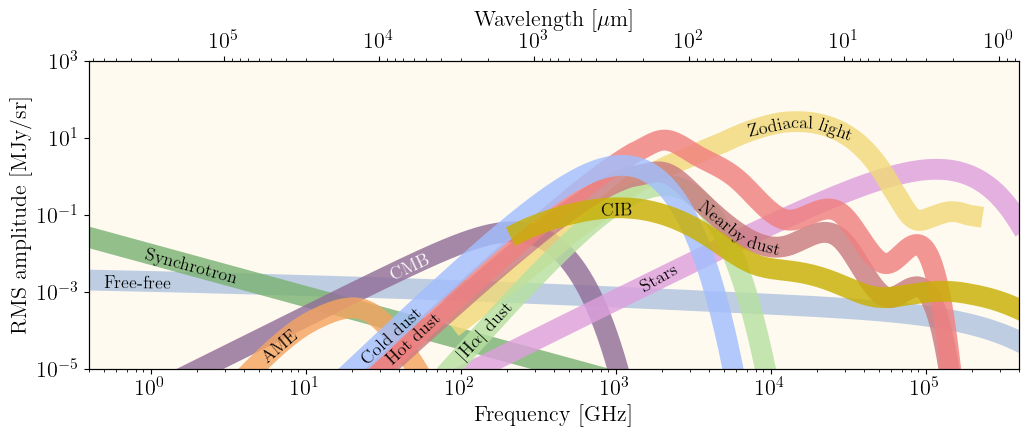

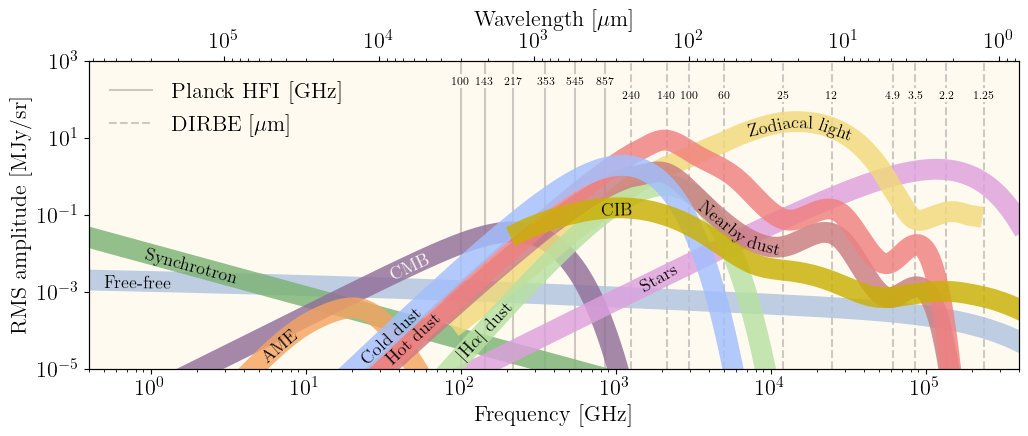

In [30]:
include_bands = [False, True]

filetypes = ['.pdf', '.png']

for include_band in include_bands:
    plt.figure(figsize=(12, 4))
    plot_comp(real_units=True, background=True, plot_bands=include_band, plot_bestfit_dust=False)
    
    for filetype in filetypes:
        band = '_bands' if include_band else ''
        plt.savefig('new_all_fgs'+band+filetype, bbox_inches='tight', dpi=300)